In [61]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
import logging
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
movie_reviews = pd.read_csv("Tonality\IMDB_Dataset.csv")

(50000, 2)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningles

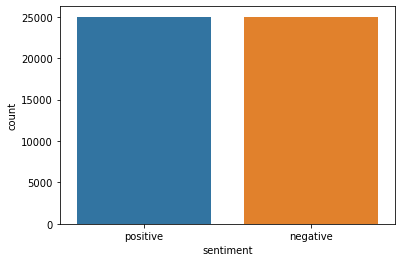

In [63]:
def watch_data(data, n):
    print(data.shape, end='\n\n')
    print(data.head(), end='\n\n')
    print(data["review"][n], end='\n\n')
    sns.countplot(x='sentiment', data=data)
    
watch_data(movie_reviews, 3)

In [64]:
def remove_tags(text):
    result = re.sub(r'<[^>]+>', '', text)
    return result

def clean_text(text):
    # Удаляем html теги
    result = remove_tags(text)

    # Удаляем все кроме слов
    result = re.sub(r'[^a-zA-Z]', ' ', result)

    # Уадляем одиночные символы
    result = re.sub(r"\s+[a-zA-Z]\s+", ' ', result)

    # Заменяем пробелы, которые идет подряд на одиночный пробел
    result = re.sub(r'\s+', ' ', result)

    return result

In [65]:
X = []
reviews = list(movie_reviews['review'])
for rev in reviews:
    X.append(clean_text(rev)) # Заполняем массив X обработанным текстом
    
y = movie_reviews['sentiment']
# Каждый y = 'positive' и т.д. преобразуем в 1 ...
y = np.array(list(map(lambda label: 1 if label=="positive" else 0, y)))

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=34)
print('X_train =', len(X_train))
print('X_test =', len(X_test))
print('y_train =', len(y_train))
print('y_test =', len(y_test))

X_train = 40000
X_test = 10000
y_train = 40000
y_test = 10000


In [67]:
print(X_train[7])

For film with so much promise it was disappointing thinly plotted and the acting ranging between horrendous and unbelievable The plot had more holes in it than swiss cheese and it the worst clich ending ve seen in movie for some time The final scene would have ripped my heart out if the entire movie hadn been so painful to begin with was numb From the very first scene one was left wondering if the sister was trying to reach out to her twin for help or simply scare her to death which would have been better for the audience and saved us from two hours of the worst acting ve seen to date It was horror in the true sense of the word 


In [68]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    sentence = tokens
    lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    
    return lemma

In [69]:
def get_train_preprocessing(X_train, y_train, cache_train_file):
    cache_train = None
    
    if cache_train_file is not None:
        try:
            cache_train = pd.read_csv(cache_train_file)
            print('Чтение тренировочных данных из кэша ...')
            data_train = []
            reviews = list(cache_train['review'])
            for rev in reviews:
                data_train.append(rev) 
        except:
            print('Не удалось прочитать данные из кэша!')
    
    if cache_train is None:
        lemmatizer = WordNetLemmatizer()
        data_train = []
        i = 0
        for x in X_train:
            x = preprocess_text(x)
            data_train.append(x)
            i += 1
            if i % 100 == 0:
                print(i/1000, '=>' , i)
        cache = pd.DataFrame({'review':data_train, 'sentiment':y_train})
        cache.to_csv(cache_train_file, index=False)
    return data_train

def get_test_preprocessing(X_test, y_test, cache_test_file):
    cache_test = None
    
    if cache_test_file is not None:
        try:
            cache_test = pd.read_csv(cache_test_file)
            print('Чтение тестовых данных из кэша ...')
            data_test = []
            reviews = list(cache_test['review'])
            for rev in reviews:
                data_test.append(rev) 
        except:
            print('Не удалось прочитать данные из кэша!')
    
    if cache_test is None:
        lemmatizer = WordNetLemmatizer()
        data_test = []
        i = 0
        for x in X_test:
            x = preprocess_text(x)
            data_test.append(x)
            i += 1
            if i % 100 == 0:
                print(i/1000, '=>' , i)
        cache = pd.DataFrame({'review':data_test, 'sentiment':y_test})
        cache.to_csv(cache_test_file, index=False)
    return data_test

def clean_cache(data):
    print('Очистка кэша ...')
    cleaned = []
    for text in data:
        text = clean_text(text)
        text = word_tokenize(text)
        cleaned.append(text)
    return cleaned 

In [70]:
X_train = get_train_preprocessing(X_train, y_train, 'Tonality\cache_train.csv')
X_train = clean_cache(X_train)

Чтение тренировочных данных из кэша ...
Очистка кэша ...


In [71]:
X_test = get_test_preprocessing(X_test, y_test, 'Tonality\cache_test.csv')
X_test = clean_cache(X_test)

Чтение тестовых данных из кэша ...
Очистка кэша ...


In [72]:
print('Train =>', len(X_train), ':', len(y_train))
print('Test =>', len(X_test), ':', len(y_test))

Train => 40000 : 40000
Test => 10000 : 10000


In [73]:
print(X_train[7][:10])

['For', 'film', 'much', 'promise', 'disappoint', 'thinly', 'plot', 'act', 'range', 'horrendous']


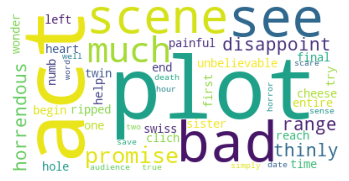

In [74]:
combined_text = " ".join(X_train[7])
wc = WordCloud(background_color='white', max_words=50,
            # update stopwords to include common words like film and movie
            stopwords = STOPWORDS.update(['film','movie']))

    # Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [86]:
def train_w2v_model(X_data):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    model = Word2Vec(
        min_count = 40,
        window = 10,
        vector_size = 300,
        workers = 4,
        sample=1e-3
        )
    
    model.build_vocab(X_data)
    
    print('Обучение модели Word2Vec ...')
    model.train(X_data, total_examples=model.corpus_count, epochs=10, report_delay=1)

    model.init_sims(replace=True)

    model_name = "300features_40minwords_10context_10epochs"
    model_path = 'Tonality\\' + model_name
    model.save(model_path)
    
def load_w2v_model(model_path):
    model = Word2Vec.load(model_path)
    
    model = None
    
    if model_path is not None:
        try:
            model = Word2Vec.load(model_path)
            print('Загрузка модели...')
        except OSError:
            print('Не удалось загрузить модель!')
    
    if model is None:
        model = False
    
    return model

In [89]:
X_data = X_train + X_test

model = load_w2v_model('Tonality\\300features_40minwords_10context_10epochs')
if model: 
    print("Модель успешно загружена")
else:
    print("Модель не была загружена!")
    train_w2v_model(X_data)

Загрузка модели...
Модель успешно загружена


In [90]:
model.wv.most_similar("comedy")

[('comedic', 0.6117552518844604),
 ('humour', 0.5829788446426392),
 ('humor', 0.5640249252319336),
 ('spoof', 0.5402818918228149),
 ('farce', 0.5338295102119446),
 ('slapstick', 0.527493417263031),
 ('satire', 0.5233971476554871),
 ('comedian', 0.4957903027534485),
 ('parody', 0.4483582079410553),
 ('Airplane', 0.42979180812835693)]

In [91]:
model.wv.doesnt_match("man woman child kitchen".split())

'kitchen'

In [92]:
model.wv.doesnt_match("car bicycle motorcycle drive".split())

'drive'

In [93]:
from gensim.models import KeyedVectors
word_vectors = model.wv
word_vectors.save("Tonality\\word2vec.wordvectors")
wv = KeyedVectors.load("Tonality\\word2vec.wordvectors", mmap='r')

In [94]:
wv['comedy']

array([-6.94660470e-02, -1.82371195e-02,  6.80305064e-02,  8.53868108e-03,
       -8.48310590e-02, -3.41191776e-02, -6.40935674e-02, -1.33778621e-02,
        7.62967300e-03, -6.71558827e-02,  5.08260503e-02, -3.23439613e-02,
       -1.23879816e-02,  1.22607788e-02,  9.21291336e-02,  1.76610854e-02,
       -7.60374814e-02, -1.08691361e-02,  9.64552909e-03, -4.32324829e-03,
        9.88918245e-02,  2.05800943e-02,  1.92083754e-02, -9.15375501e-02,
       -2.61050332e-02,  3.07635870e-02,  3.35012302e-02, -2.14801468e-02,
        1.72105096e-02,  1.13480568e-01,  7.97747076e-02,  1.19959266e-04,
        8.42049867e-02, -5.09323590e-02, -1.16530750e-02, -1.15683757e-01,
       -4.16797074e-03,  3.06431316e-02, -3.62769179e-02, -7.66606852e-02,
        9.15847793e-02,  4.66264971e-02,  4.77912501e-02,  1.14400007e-01,
        4.08707093e-03, -1.08123995e-01, -1.49807371e-02, -1.77974571e-02,
        9.63611470e-04, -1.71163585e-04, -7.87037145e-03, -2.02019364e-02,
        6.78580925e-02, -

In [95]:
def clean_nn(data):
    print('Очистка кэша ...')
    cleaned = []
    for text in data:
        text = clean_text(text)
        cleaned.append(text)
    return cleaned 

X_train = get_train_preprocessing(X_train, y_train, 'Tonality\cache_train.csv')
X_train = clean_nn(X_train)

X_test = get_test_preprocessing(X_test, y_test, 'Tonality\cache_test.csv')
X_test = clean_nn(X_test)

X_data = X_train + X_test

Чтение тренировочных данных из кэша ...
Очистка кэша ...
Чтение тестовых данных из кэша ...
Очистка кэша ...


In [96]:
print(X_data[1])

 know people consider trashy obnoxious It like American Pie something know people offend Universal plug since part plot advertising excusable This funny movie good dialogue good subtle wit good story good moral thankfully get sappy GREAT act cheesy end minor spoiler The basic premise classic story Shepherd boy Muniz lie much one believe Wolf Giamatti come along So get best friend Kaylee Bynes go drive Wolf crazy Frankie Muniz annoy role Jason Shepherd He handle suave confidence character perfectly well appear lack expression first glance really perfectly execute nonchalantness Amanda Bynes What say The girl get gift She funny talented versatile attractive month old need get California sometime soon In fact best friend part originally boy become girl soon maker saw Amanda interest Which work pretty well since part would pretty dull without blessing Bynes ability Paul Giamatti talented man While would play Marty Wolf evil diabolical Giamatti make jerk mind LIKEABLE jerk jerk livens scree

In [97]:
y_data = []
for y in y_train:
    y_data.append(y)
for y in y_test:
    y_data.append(y)

In [98]:
print(y_data[1])

1


In [99]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer=None,
                              preprocessor=None, stop_words = None,
                              max_features=10000)

train_data_features = vectorizer.fit_transform(X_data)
train_data_features = train_data_features.toarray()

In [100]:
train_data_features.shape

(50000, 10000)

In [101]:
CountVectorizedData=pd.DataFrame(train_data_features, columns=vectorizer.get_feature_names())
CountVectorizedData['Sentiment']=y_data

In [102]:
print(CountVectorizedData.shape)
CountVectorizedData.head()

(50000, 10001)


,aamir,aaron,ab,abandon,abbey,abbott,abc,abduct,abduction,ability,...,zoey,zombi,zombie,zombies,zone,zoo,zoom,zorro,zucco,Sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [103]:
WordsVocab=CountVectorizedData.columns[:-1]
WordsVocab[0:10]

Index(['aamir', 'aaron', 'ab', 'abandon', 'abbey', 'abbott', 'abc', 'abduct',
       'abduction', 'ability'],
      dtype='object')

In [104]:
'zombie' in wv.key_to_index.keys()

True

In [105]:
wv.most_similar('zombie', topn=5)

[('undead', 0.6330141425132751),
 ('Zombie', 0.5931744575500488),
 ('monster', 0.5102360248565674),
 ('vampire', 0.4970807135105133),
 ('Zombies', 0.49323582649230957)]

In [106]:
def Text2Vec(text_data):
    # Преобразуем текст в числовые данные
    X = vectorizer.transform(text_data)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    # Создание пустого фрейма данных для хранения предложений
    W2Vec_Data=pd.DataFrame()
    
    # Перебираем каждую строку в поисках данных
    for i in range(CountVecData.shape[0]):
        if i % 1000 == 0:
            print('[{}/50] => {}'.format(i / 1000, i))
        
        # Инициализируем предложение нулями
        Sentence = np.zeros(300)
        
        # Перебираем каждое слово в предложении и, если оно присутствует в модели Word2Vec, сохраняем его вектор
        for word in WordsVocab[CountVecData.iloc[i,:] >= 1]:
            # print(word)
            if word in wv.key_to_index.keys():    
                Sentence=Sentence+wv[word]
        # Добавляем предложение в датафрэйм
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [107]:
def load_ML_Data(cache_path):
    cache_data = None
    
    if cache_path is not None:
        try:
            cache_data = pd.read_pickle(cache_path)
            print('Чтение данных из кэша ...')
        except:
            print('Не удалось прочитать данные из кэша!')
    
    if cache_data is None:
        cache_data = False
        
    return cache_data

In [109]:
ML_Data = load_ML_Data("Tonality\\MachineLearning_Data.pkl")

if isinstance(ML_Data, pd.DataFrame): 
    print("Данные успешно загружены из кэша")
else:
    print("Данные из кэша не были загружены")
    W2Vec_Data = Text2Vec(X_data_nn)

    W2Vec_Data.shape
    CountVectorizedData.shape # Сравниваем

    W2Vec_Data.reset_index(inplace=True, drop=True)
    W2Vec_Data['Sentiment']=CountVectorizedData['Sentiment']

    ML_Data = W2Vec_Data
    ML_data.to_pickle("Tonality\\MachineLearning_Data.pkl")
    
ML_Data.info()
ML_Data.head()

Чтение данных из кэша ...
Данные успешно загружены из кэша
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 301 entries, 0 to Sentiment
dtypes: float64(300), int32(1)
memory usage: 114.6 MB


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Sentiment
0,0.209064,-1.041453,-0.051072,-1.278353,0.074339,0.541576,-1.189507,-1.340200,-0.374054,0.423989,...,-1.430041,-0.731737,-0.602550,-0.771445,-1.174658,0.137484,1.355606,-0.564687,-0.506003,0
1,-1.033997,-0.734089,1.246042,-1.379258,-1.493581,1.109292,-0.581578,-2.689771,0.645435,-0.143893,...,-3.245718,-1.332235,-0.637611,-3.557307,-3.420019,-0.464975,2.308958,-0.135784,0.559531,1
2,-0.251900,0.023798,1.058991,-1.668829,0.109816,0.526867,-0.644322,-1.475990,-0.821424,0.800708,...,-1.635752,0.687690,-0.332628,-2.282085,-1.282987,0.956784,1.259151,-0.247593,-0.008013,0
3,-0.898389,-1.001425,0.174482,-0.911301,-0.611055,0.359247,0.016223,-1.023431,-0.196303,-0.222088,...,-1.671042,0.036104,0.474964,-1.617957,-1.355517,-0.225269,1.017523,-0.799487,-0.570912,1
4,-0.224863,0.393978,-0.041550,-0.713631,-0.732334,-0.067383,-1.008623,-1.210305,0.551219,0.276769,...,-1.715263,0.142970,0.265695,-0.710987,-2.422062,0.583585,1.327371,-0.700736,-0.680903,1


In [110]:
Target = ML_Data.columns[-1]
Predictors = ML_Data.columns[:-1]

X=ML_Data[Predictors].values
y=ML_Data[Target].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=341)
print('X_train =', X_train.shape)
print('X_test =', X_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)

X_train = (40000, 300)
X_test = (10000, 300)
y_train = (40000,)
y_test = (10000,)


In [116]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
RandForest = RandomForestClassifier(n_estimators=100)
RandForest = RandForest.fit(X_train, y_train)

In [117]:
RandForest_predict = RandomForest.predict(X_test)
accuracy_score(y_test, RandForest_predict)

0.8542

In [118]:
print(classification_report(y_test, RandForest_predict))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5037
           1       0.85      0.86      0.85      4963

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [119]:
def preprocess_test_review(review): 
    text = clean_text(review)
    lemma = preprocess_text(text) # Токенизация и Лемматизация
    
    text = ' '.join(map(str, lemma))
    x = []
    x.append(text)
    
    x = Text2Vec(x)
    predictors = x.columns[:]
    result = x[predictors].values
    return result

test_review_ice = "This movie is so excellent! It got my adrenalin pumping. Begin again, dreams will come true finally. I was also touched by their love. When you want to give up, love will give you courage to move on."
target_review_ice = 1
print(test_review_ice, target_review_ice)

lemmatizer = WordNetLemmatizer()
pre_review = preprocess_test_review(test_review_ice)
pre_review.shape

y_pred_review_ice = RandForest.predict(pre_review)
if y_pred_review_ice[0] == target_review_ice:
    print("Эмоциональная окраска отзыва была предсказана ВЕРНО")
else:
    print("Отзыв предсказн НЕ ВЕРНО")

This movie is so excellent! It got my adrenalin pumping. Begin again, dreams will come true finally. I was also touched by their love. When you want to give up, love will give you courage to move on. 1
[0.0/50] => 0
Эмоциональная окраска отзыва была предсказана ВЕРНО


In [123]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(max_iter = 500)
log_regr.fit(X_train, y_train)

log_predict = log_regr.predict(X_test)
print(accuracy_score(y_test, log_predict))
print(classification_report(y_test, log_predict))

0.8758
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5037
           1       0.87      0.89      0.88      4963

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [124]:
from sklearn.preprocessing import StandardScaler

StandSC = StandardScaler()

X_train_NB = StandSC.fit_transform(X_train)
X_test_NB = StandSC.transform(X_test)

from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()
NaiveBayes.fit(X_train_NB, y_train)

NaiveBayes_predict = NaiveBayes.predict(X_test_NB)
print(accuracy_score(y_test, NaiveBayes_predict))
print(classification_report(y_test, NaiveBayes_predict))

0.7755
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      5037
           1       0.80      0.73      0.76      4963

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000

